Working with the public 10-year IceCube point-source data
==

This tutorial shows how to use the IceCube public 10-year point-source data with SkyLLH.

**Disclaimer**

    The released 10-year IceCube point-source data can reproduce the published results only within a certain
    amount of uncertainty due to the limited instrument response function binning provided in the data release.
    The IceCube collaboration is able to reproduce the published results using detailed direct simulation
    data, as done for the publication.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from matplotlib import pyplot as plt

Getting the datasets
---

First we import the dataset definition of the public 10-year point-source data set:

In [3]:
from skyllh.datasets.i3.PublicData_10y_ps import create_dataset_collection

The collection of datasets can be created using the ``create_dataset_collection`` function. This function requires the base path to the data repository. It's the path where the public point-source data is stored. The public point-source data can be downloaded from the [IceCube website](http://icecube.wisc.edu/data-releases/20210126_PS-IC40-IC86_VII.zip).

In [4]:
dsc = create_dataset_collection(base_path='/home/mwolf/projects/publicdata_ps/')

The ``dataset_names`` property provides a list of all the data sets defined in the data set collection of the public point-source data.

In [5]:
dsc.dataset_names

['IC40',
 'IC59',
 'IC79',
 'IC86_I',
 'IC86_II',
 'IC86_II-VII',
 'IC86_III',
 'IC86_IV',
 'IC86_V',
 'IC86_VI',
 'IC86_VII']

The individual data sets ``IC86_II``, ``IC86_III``, ``IC86_IV``, ``IC86_V``, ``IC86_VI``, and ``IC86_VII`` are also available as a single combined data set ``IC86_II-VII``, because these data sets share the same detector simulation and event selection. Hence, we can get a list of data sets via the ``get_datasets`` method of the ``dsc`` instance:

In [6]:
datasets = dsc.get_datasets(['IC40', 'IC59', 'IC79', 'IC86_I', 'IC86_II-VII'])

Getting the analysis
---

The analysis used for the published PRL results is referred in SkyLLH as "*traditional point-source analysis*" and is pre-defined:

In [7]:
from skyllh.analyses.i3.publicdata_ps.time_integrated_ps import create_analysis

In [8]:
help(create_analysis)

Help on function create_analysis in module skyllh.analyses.i3.publicdata_ps.time_integrated_ps:

create_analysis(datasets, source, refplflux_Phi0=1, refplflux_E0=1000.0, refplflux_gamma=2, ns_seed=10.0, gamma_seed=3, kde_smoothing=False, minimizer_impl='LBFGS', cap_ratio=False, compress_data=False, keep_data_fields=None, optimize_delta_angle=10, tl=None, ppbar=None)
    Creates the Analysis instance for this particular analysis.
    
    Parameters:
    -----------
    datasets : list of Dataset instances
        The list of Dataset instances, which should be used in the
        analysis.
    source : PointLikeSource instance
        The PointLikeSource instance defining the point source position.
    refplflux_Phi0 : float
        The flux normalization to use for the reference power law flux model.
    refplflux_E0 : float
        The reference energy to use for the reference power law flux model.
    refplflux_gamma : float
        The spectral index to use for the reference power l

As source we use TXS 0506+056.

In [9]:
from skyllh.physics.source import PointLikeSource

In [10]:
source = PointLikeSource(ra=np.deg2rad(77.35), dec=np.deg2rad(5.7))

In [11]:
ana = create_analysis(datasets=datasets, source=source)

[==========================================================] 100% ELT 0h:00m:14s[                                                          ]   0% ELT 0h:00m:00s
[==========================================================] 100% ELT 0h:00m:13s[                                                          ]   0% ELT 0h:00m:00s
[==========================================================] 100% ELT 0h:00m:13s[                                                          ]   0% ELT 0h:00m:00s
[==========================================================] 100% ELT 0h:00m:13s[                                                          ]   0% ELT 0h:00m:00s
[==========================================================] 100% ELT 0h:00m:12s[                                                          ]   0% ELT 0h:00m:00s
[==========================================================] 100% ELT 0h:01m:36s
[==========================================================] 100% ELT 0h:00m:00s


Initializing a trial
---

After the `Analysis` instance was created trials can be run. To do so the analysis needs to be initialized with some trial data. For instance we could initialize the analysis with the experimental data to "unblind" the analysis afterwards. Technically the `TrialDataManager` of each log-likelihood ratio function, i.e. dataset, is initialized with data.

The `Analysis` class provides the method `initialize_trial` to initialize a trial with data. It takes a list of `DataFieldRecordArray` instances holding the events. If we want to initialize a trial with the experimental data, we can get that list from the `Analysis` instance itself:

In [32]:
events_list = [ data.exp for data in ana.data_list ]
ana.initialize_trial(events_list)

Maximizing the log-likelihood ratio function
---

After initializing a trial, we can maximize the LLH ratio function using the `maximize_llhratio` method of the `Analysis` class. This method requires a ``RandomStateService`` instance in case the minimizer does not succeed and a new set of initial values for the fit parameters need to get generated. The method returns a 4-element tuple. The first element is the set of fit parameters used in the maximization. The second element is the value of the LLH ration function at its maximum. The third element is the array of the fit parameter values at the maximum, and the forth element is the status dictionary of the minimizer.

In [39]:
from skyllh.core.random import RandomStateService
rss = RandomStateService(seed=1)

In [40]:
(fitparamset, log_lambda_max, fitparam_values, status) = ana.maximize_llhratio(rss)

In [44]:
print(f'log_lambda_max = {log_lambda_max}')
print(f'fitparam_values = {fitparam_values}')
print(f'status = {status}')

log_lambda_max = 6.572529558548655
fitparam_values = [14.58039149  2.1685849 ]
status = {'grad': array([-2.09454353e-06,  2.13693588e-04]), 'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 15, 'nit': 9, 'warnflag': 0, 'skyllh_minimizer_n_reps': 0, 'n_llhratio_func_calls': 15}


Calculating the test-statistic
---

Using the maximum of the LLH ratio function and the fit parameter values at the maximum we can calculate the test-statistic using the `calculate_test_statistic` method of the `Analysis` class:

In [48]:
TS = ana.calculate_test_statistic(log_lambda_max, fitparam_values)
print(f'TS = {TS:.3f}')

TS = 13.145


## Unblinding the data

After creating the analysis instance we can unblind the data for the choosen source. Hence, we initialize the analysis with a trial of the experimental data, maximize the log-likelihood ratio function for all given experimental data events, and calculate the test-statistic value. The analysis instance has the method ``unblind`` that can be used for that. This method requires a ``RandomStateService`` instance in case the minimizer does not succeed and a new set of initial values for the fit parameters need to get generated.

In [35]:
from skyllh.core.random import RandomStateService
rss = RandomStateService(seed=1)

In [13]:
help(ana.unblind)

Help on method unblind in module skyllh.core.analysis:

unblind(rss) method of skyllh.core.analysis.TimeIntegratedMultiDatasetSingleSourceAnalysis instance
    Evaluates the unscrambled data, i.e. unblinds the data.
    
    Parameters
    ----------
    rss : RandomStateService instance
        The RandomStateService instance that should be used draw random
        numbers from.
    
    Returns
    -------
    TS : float
        The test-statistic value.
    fitparam_dict : dict
        The dictionary holding the global fit parameter names and their best
        fit values.
    status : dict
        The status dictionary with information about the performed
        minimization process of the negative of the log-likelihood ratio
        function.



The ``unblind`` method returns the test-statistic value, the best-fit fit parameter values, and a status dictionary of the minimizer.

In [14]:
(ts, x, status) = ana.unblind(rss=rss)

In [15]:
print(f'TS = {ts:.3f}')
print(f'ns = {x["ns"]:.2f}')
print(f'gamma = {x["gamma"]:.2f}')

TS = 13.145
ns = 14.58
gamma = 2.17


## Calculating the corresponding flux normalization 

By default the analysis is created with a flux normalization of 1 GeV$^{-1}$s$^{-1}$cm$^{-2}$sr$^{-1}$ (see `refplflux_Phi0` argument of the `create_analysis` method). The analysis instance has the method `calculate_fluxmodel_scaling_factor` that calculates the scaling factor the reference flux normalization has to be multiplied with to represent a given analysis result, i.e. $n_{\text{s}}$ and $\gamma$ value. This function takes the detected mean $n_{\text{s}}$ value as first argument and the list of source parameter values as second argument:

In [16]:
scaling_factor = ana.calculate_fluxmodel_scaling_factor(x['ns'], [x['gamma']])
print(f'Flux scaling factor = {scaling_factor:.3e}')

Flux scaling factor = 1.423e-15


Hence, our result corresponds to a power-law flux of:

In [17]:
print(f'{scaling_factor:.3e}'' (E/1000 GeV)^{-'f'{x["gamma"]:.2f}'+'} 1/(GeV s cm^2 sr)')

1.423e-15 (E/1000 GeV)^{-2.17} 1/(GeV s cm^2 sr)


Evaluating the log-likelihood ratio function
---

Sometimes it is useful to be able to evaluate the log-likelihood ratio function, e.g. for creating a likelihood contour plot. Because SkyLLH's structure is based on the mathematical structure of the likelihood function, the `Analysis` instance has the property `llhratio` which is the class instance of the used log-likelihood ratio function. This instance has the method `evaluate`. The method takes an array of the fit parameter values as argument at which the LLH ratio function will be evaluated. It returns the value of the LLH ratio function at the given point and its gradients w.r.t. the fit parameters.

In our case this is the number of signal events, $n_{\mathrm{s}}$ and the spectral index $\gamma$. If we evaluate the LLH ratio function at the maximum, the gradients should be close to zero.

In [31]:
help(ana.llhratio.evaluate)

Help on method evaluate in module skyllh.core.llhratio:

evaluate(fitparam_values, tl=None) method of skyllh.core.llhratio.MultiDatasetTCLLHRatio instance
    Evaluates the composite log-likelihood-ratio function and returns its
    value and global fit parameter gradients.
    
    Parameters
    ----------
    fitparam_values : (N_fitparams)-shaped numpy 1D ndarray
        The ndarray holding the current values of the global fit parameters.
        The first element of that array is, by definition, the number of
        signal events, ns.
    
    Returns
    -------
    log_lambda : float
        The calculated log-lambda value of the composite
        log-likelihood-ratio function.
    grads : (N_fitparams,)-shaped 1D ndarray
        The ndarray holding the gradient value of the composite
        log-likelihood-ratio function for ns and each global fit parameter.
        By definition the first element is the gradient for ns.



In [29]:
(llhratio_value, (grad_ns, grad_gamma)) = ana.llhratio.evaluate([14.58, 2.17])
print(f'llhratio_value = {llhratio_value:.3f}')
print(f'grad_ns = {grad_ns:.3f}')
print(f'grad_gamma = {grad_gamma:.3f}')

llhratio_value = 6.573
grad_ns = 0.001
grad_gamma = -0.027


Using the `evaluate` method of the `LLHRatio` class we can scan the log-likelihood ratio space and create a contour plot showing the best fit and the 95% quantile.

In [136]:
(ns_min, ns_max, ns_step) = (0, 80, 0.5)
(gamma_min, gamma_max, gamma_step) = (1.5, 4.0, 0.1)

ns_edges = np.linspace(ns_min, ns_max, int((ns_max-ns_min)/ns_step)+1)
ns_vals = 0.5*(ns_edges[1:] + ns_edges[:-1])

gamma_edges = np.linspace(gamma_min, gamma_max, int((gamma_max-gamma_min)/gamma_step+1))
gamma_vals = 0.5*(gamma_edges[1:] + gamma_edges[:-1])

log_lambda = np.empty((len(ns_vals), len(gamma_vals)), dtype=np.double)
for (ns_i, ns) in enumerate(ns_vals):
    for (gamma_i, gamma) in enumerate(gamma_vals):
        log_lambda[ns_i,gamma_i] = ana.llhratio.evaluate([ns, gamma])[0]

# Determine the best fit ns and gamma values from the scan.
index_max = np.argmax(log_lambda)
ns_i_max = int(index_max / len(gamma_vals))
gamma_i_max = index_max % len(gamma_vals)
ns_best = ns_vals[ns_i_max]
gamma_best = gamma_vals[gamma_i_max]

(1.5, 4.0)

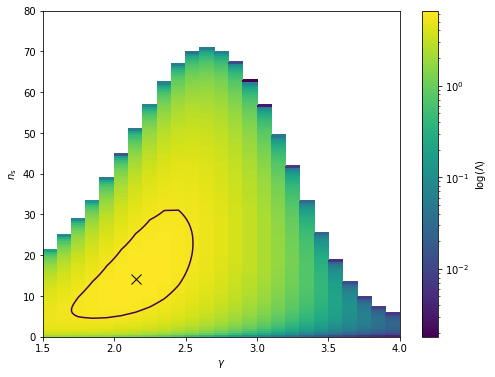

In [137]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(8,6))
plt.pcolormesh(gamma_edges, ns_edges, log_lambda, norm=LogNorm())
cbar = plt.colorbar()
cbar.set_label(r'$\log(\Lambda)$')
plt.contour(gamma_vals, ns_vals, log_lambda, [np.quantile(log_lambda, 0.95)])
plt.plot(gamma_best, ns_best, marker='x', color='black', ms=10)
plt.xlabel(r'$\gamma$')
plt.ylabel(r'$n_{\mathrm{s}}$')
plt.ylim(ns_min, ns_max)
plt.xlim(gamma_min, gamma_max)

Calculating the significance (local p-value)
---

The significance of the source, i.e. the local p-value, can be calculated by generating the test-statistic distribution of background-only data trials, i.e. for zero injected signal events. SkyLLH provides the helper function ``create_trial_data_file`` to do that:

In [18]:
from skyllh.core.analysis_utils import create_trial_data_file

In [19]:
help(create_trial_data_file)

Help on function create_trial_data_file in module skyllh.core.analysis_utils:

create_trial_data_file(ana, rss, n_trials, mean_n_sig=0, mean_n_sig_null=0, mean_n_bkg_list=None, bkg_kwargs=None, sig_kwargs=None, pathfilename=None, ncpu=None, ppbar=None, tl=None)
    Creates and fills a trial data file with `n_trials` generated trials for
    each mean number of injected signal events from `ns_min` up to `ns_max` for
    a given analysis.
    
    Parameters
    ----------
    ana : instance of Analysis
        The Analysis instance to use for the trial generation.
    rss : RandomStateService
        The RandomStateService instance to use for generating random
        numbers.
    n_trials : int
        The number of trials to perform for each hypothesis test.
    mean_n_sig : ndarray of float | float | 2- or 3-element sequence of float
        The array of mean number of injected signal events (MNOISEs) for which
        to generate trials. If this argument is not a ndarray, an array o

At first we will generate 10k trials and look at the test-statistic distribution. We will time the trial generation using the ``TimeLord`` class.

In [20]:
from skyllh.core.timing import TimeLord
tl = TimeLord()

In [21]:
rss = RandomStateService(seed=1)
(_, _, _, trials) = create_trial_data_file(
    ana=ana,
    rss=rss,
    n_trials=1e4,
    mean_n_sig=0,
    pathfilename='/home/mwolf/projects/publicdata_ps/txs_bkg_trails.npy',
    ncpu=8,
    tl=tl)
print(tl)

[==========================================================] 100% ELT 0h:07m:31s
TimeLord: Executed tasks:
[Generating background events for data set 0.]   0.002 sec/iter (10000)
[Generating background events for data set 1.]   0.003 sec/iter (10000)
[Generating background events for data set 2.]   0.003 sec/iter (10000)
[Generating background events for data set 3.]   0.005 sec/iter (10000)
[Generating background events for data set 4.]   0.024 sec/iter (10000)
[Generating pseudo data.                     ]   0.030 sec/iter (10000)
[Initializing trial.                         ]   0.030 sec/iter (10000)
[Create fitparams dictionary.                ] 1.0e-05 sec/iter (593990)
[Calc fit param dep data fields.             ] 2.9e-06 sec/iter (593990)
[Get sig prob.                               ] 1.8e-04 sec/iter (593990)
[Evaluating bkg log-spline.                  ] 2.6e-04 sec/iter (593990)
[Get bkg prob.                               ] 3.2e-04 sec/iter (593990)
[Calc PDF ratios.       

After generating the background trials, we can histogram the test-statistic values and plot the TS distribution.

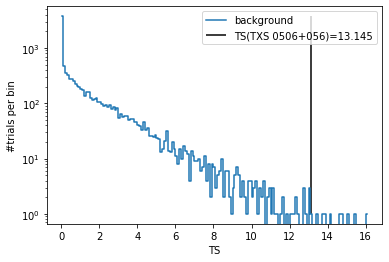

In [22]:
(h, be) = np.histogram(trials['ts'], bins=np.arange(0, np.max(trials['ts'])+0.1, 0.1))
plt.plot(0.5*(be[:-1]+be[1:]), h, drawstyle='steps-mid', label='background')
plt.vlines(ts, 1, np.max(h), label=f'TS(TXS 0506+056)={ts:.3f}')
plt.yscale('log')
plt.xlabel('TS')
plt.ylabel('#trials per bin')
plt.legend()
pass

We can see that the TS value of the unblinded data for TXS is rather large and 10k trials are not enough to calculate a reliable estimate for the p-value. Hence, we will generate a few more trials. SkyLLH provides also a helper function to extend the trial data file we just created. It is called ``extend_trial_data_file``: 

In [23]:
from skyllh.core.analysis_utils import extend_trial_data_file

In [24]:
help(extend_trial_data_file)

Help on function extend_trial_data_file in module skyllh.core.analysis_utils:

extend_trial_data_file(ana, rss, n_trials, trial_data, mean_n_sig=0, mean_n_sig_null=0, mean_n_bkg_list=None, bkg_kwargs=None, sig_kwargs=None, pathfilename=None, **kwargs)
    Appends to the trial data file `n_trials` generated trials for each
    mean number of injected signal events up to `ns_max` for a given analysis.
    
    Parameters
    ----------
    ana : Analysis
        The Analysis instance to use for sensitivity estimation.
    rss : RandomStateService
        The RandomStateService instance to use for generating random
        numbers.
    n_trials : int
        The number of trials the trial data file needs to be extended by.
    trial_data : structured numpy ndarray
        The structured numpy ndarray holding the trials.
    mean_n_sig : ndarray of float | float | 2- or 3-element sequence of float
        The array of mean number of injected signal events (MNOISEs) for which
        to gen

In [25]:
tl = TimeLord()
rss = RandomStateService(seed=2)
trials = extend_trial_data_file(
    ana=ana,
    rss=rss,
    n_trials=4e4,
    trial_data=trials,
    pathfilename='/home/mwolf/projects/publicdata_ps/txs_bkg_trails.npy',
    ncpu=8,
    tl=tl)

[==========================================================] 100% ELT 0h:29m:56s


In [26]:
print(tl)

TimeLord: Executed tasks:
[Generating background events for data set 0.]   0.002 sec/iter (40000)
[Generating background events for data set 1.]   0.003 sec/iter (40000)
[Generating background events for data set 2.]   0.003 sec/iter (40000)
[Generating background events for data set 3.]   0.005 sec/iter (40000)
[Generating background events for data set 4.]   0.019 sec/iter (40000)
[Generating pseudo data.                     ]   0.027 sec/iter (40000)
[Initializing trial.                         ]   0.032 sec/iter (40000)
[Create fitparams dictionary.                ] 1.1e-05 sec/iter (2375320)
[Calc fit param dep data fields.             ] 3.3e-06 sec/iter (2375320)
[Get sig prob.                               ] 2.0e-04 sec/iter (2375320)
[Evaluating bkg log-spline.                  ] 2.8e-04 sec/iter (2375320)
[Get bkg prob.                               ] 3.5e-04 sec/iter (2375320)
[Calc PDF ratios.                            ] 6.8e-05 sec/iter (2375320)
[Calc pdfratio values.    

The local p-value is defined as the fraction of background trials with TS value greater than the unblinded TS value of the source. 

In [27]:
minus_log10_pval = -np.log10(len(trials[trials['ts'] > ts]) / len(trials))
print(f'-log10(p_local) = {minus_log10_pval:.2f}')

-log10(p_local) = 2.93


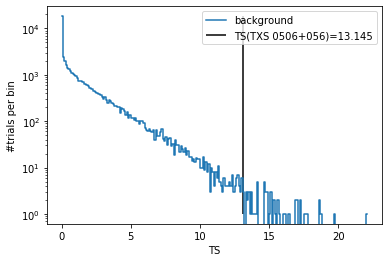

In [28]:
(h, be) = np.histogram(trials['ts'], bins=np.arange(0, np.max(trials['ts'])+0.1, 0.1))
plt.plot(0.5*(be[:-1]+be[1:]), h, drawstyle='steps-mid', label='background')
plt.vlines(ts, 1, np.max(h), label=f'TS(TXS 0506+056)={ts:.3f}')
plt.yscale('log')
plt.xlabel('TS')
plt.ylabel('#trials per bin')
plt.legend()
pass